# Pyhton数据分析:银行电话营销数据分析

## 一、前言
### 项目介绍：
在我们的日常生活中，银行为我们的财产提供了基本的安全保障，便利了我们的生活，而我们在银行的一些记录信息，方便了银行对我们进行一些行为预测，本项目则根据客户的以往记录信息，预测客户是否办理存款业务。


### 数据集分析
该项目的数据集对应的任务是「分类任务」，本数据集共包含25317行，18列数据，其中字段为y的列是标签列，包含0和1两个值，0表示不订购业务，1表示订购业务，其他列是特征列
### 字段的描述
ID：客户唯一标识<br>
age：客户年龄<br>
job：客户的职业<br>
marital：婚姻状况<br>
education：受教育水平<br>
default：是否有违约记录<br>
balance：每年账户的平均余额<br>
housing：是否有住房贷款<br>
loan：是否有个人贷款<br>
contact：与客户联系的沟通方式<br>
day：最后一次联系的时间（几号）<br>
month：最后一次联系的时间（月份）<br>
duration：最后一次联系的交流时长<br>
campaign：在本次活动中，与该客户交流过的次数<br>
pdays：距离上次活动最后一次联系该客户，过去了多久<br>
previous：在本次活动之前，与该客户交流过的次数<br>
poutcome：上一次活动的结果<br>
y：客户是否会订购定期存款业务，0表示不订购，1表示订购<br>

## 二、提出问题
* 哪个分类模型更适合预测客户是否订购定期存款业务？

### 分析流程
* 查看数据
* 特征处理
* 选择模型
* 数据归一化

## 三、探索性数据分析
### 导入必备的库

In [1]:
#Basic library
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#machine learning
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import LabelEncoder, MinMaxScaler

#Model
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

#igonore warnings
import warnings
warnings.filterwarnings('ignore')

### 查看数据

In [2]:
data_all = pd.read_csv('./dataFile/train_set.csv',index_col='ID')
data_all.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
ID,,,,,,,,,,,,,,,,,
1,43,management,married,tertiary,no,291,yes,no,unknown,9,may,150,2,-1,0,unknown,0
2,42,technician,divorced,primary,no,5076,yes,no,cellular,7,apr,99,1,251,2,other,0
3,47,admin.,married,secondary,no,104,yes,yes,cellular,14,jul,77,2,-1,0,unknown,0
4,28,management,single,secondary,no,-994,yes,yes,cellular,18,jul,174,2,-1,0,unknown,0
5,42,technician,divorced,secondary,no,2974,yes,no,unknown,21,may,187,5,-1,0,unknown,0


In [3]:
#查看数据的基本信息
data_all.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 25317 entries, 1 to 25317
Data columns (total 17 columns):
age          25317 non-null int64
job          25317 non-null object
marital      25317 non-null object
education    25317 non-null object
default      25317 non-null object
balance      25317 non-null int64
housing      25317 non-null object
loan         25317 non-null object
contact      25317 non-null object
day          25317 non-null int64
month        25317 non-null object
duration     25317 non-null int64
campaign     25317 non-null int64
pdays        25317 non-null int64
previous     25317 non-null int64
poutcome     25317 non-null object
y            25317 non-null int64
dtypes: int64(8), object(9)
memory usage: 3.5+ MB


In [4]:
# 查看数据data_all的维度
data_all.shape

(25317, 17)

In [6]:
# 查看每列数据是否包含缺失值。
data_all.isnull().any()

age          False
job          False
marital      False
education    False
default      False
balance      False
housing      False
loan         False
contact      False
day          False
month        False
duration     False
campaign     False
pdays        False
previous     False
poutcome     False
y            False
dtype: bool

显然，数据集中不包含任何缺失值。

### 特征处理

In [7]:
# 获得data_all中列的数据类型是object的列的列名。
data_obj_col = data_all.select_dtypes('object').columns.to_list()
data_obj_col

['job',
 'marital',
 'education',
 'default',
 'housing',
 'loan',
 'contact',
 'month',
 'poutcome']

In [9]:
# 获得数据集中列的数据类型为object的所有数据，以及打印数据的维度
data_obj=data_all[data_obj_col]
data_obj.shape

(25317, 9)

In [10]:
# 依据data_obj_col，获得数据集中列的数据类型为数值型的列的列。
data_num_col = data_all.columns.difference(data_obj_col)

In [11]:
# 获得数据集中列的数据类型为数值型的所有数据，以及数据的维度
data_num=data_all[data_num_col]
data_num.shape

(25317, 8)

In [12]:
# 打印data_num的列名
data_num.columns.to_list()

['age', 'balance', 'campaign', 'day', 'duration', 'pdays', 'previous', 'y']

从以上输出的数据可知:
* Object类型的列有9个
* 数值类型的列有8个，数值类型的列名分别为：'age', 'balance', 'campaign', 'day', 'duration', 'pdays', 'previous','y'

### 标签编码
将object类型的列中只有两个值的列进行标签编码，将编码后的列添加到data_num数据集中

In [13]:
# 计算data_obj中每列中的唯一值；然后得到每一列中只有两个值的列名
two_unique_cols = data_obj.nunique()[data_obj.nunique()==2].index.tolist()
two_unique_cols

['default', 'housing', 'loan']

In [14]:
# 对列中唯一值只有两个值的列进行标签编码，将标签编码后的数据存到data_num数据集中
y = data_all[two_unique_cols].apply(LabelEncoder().fit_transform)
data_num = pd.concat([y, data_num],ignore_index=False, sort=True, axis=1)

In [15]:
# 打印data_num的维度和列名
print('data_num的维度是：{}'.format(data_num.shape))
data_num.columns

data_num的维度是：(25317, 11)


Index(['default', 'housing', 'loan', 'age', 'balance', 'campaign', 'day',
       'duration', 'pdays', 'previous', 'y'],
      dtype='object')

### 数据抽样
由于建模的时候，样本不平衡会对模型的训练产生很大的影响，这里将采取简单的方法对数据进行抽样，以使y中每类的样本相对平衡

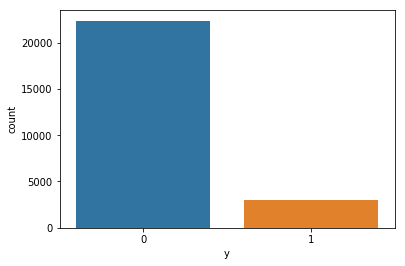

In [16]:
# 使用countplot对y列的唯一值进行画图显示
sns.countplot(data_num['y'])

In [17]:
# 标签列y中存在两个唯一值，现在计算每个值的个数.
data_num['y'].value_counts()
value_0 = (data_num['y']==0).sum()
value_1 = (data_num['y']==1).sum()
print("0有:{},1有:{}".format(value_0,value_1))

0有:22356,1有:2961


从以上的输出和图的显示来看,y标签列的每类的样本数不一致,因此为保抽取样本的平衡，对y==0的样本进行随机抽样。

In [18]:
# 以上可知y中列存在0和1两个值，由于0包含的元素个数远远大于1的个数，现在使用sample从y为0的样本中随机抽取一些样本，
# 要求0包含的样本数和1的样本数相同，且随机种子设定为22，
# sample随机抽样方法：sample(n=样本数，random_state=随机种子数)
data_num_0 = data_num[data_num['y']==0].sample(n=value_1, random_state=22)

In [19]:
# 得到数据集中y列中为1的样本
data_num_1=data_num[data_num['y']!=0]

In [20]:
# 将y为1的样本和随机抽取的y为0的样本进行合并，并且打印合并后数据集的维度
data_num_sample = pd.concat([data_num_0,data_num_1], axis=0, ignore_index=False)
data_num_sample.shape

(5922, 11)

In [21]:
# 对数据集拆分为训练集和测试集之前，先检查下数据是否存在问题，调用describe，打印下数据的统计信息
data_num_sample.describe()

,default,housing,loan,age,balance,campaign,day,duration,pdays,previous,y
count,5922.000000,5922.000000,5922.000000,5922.000000,5922.000000,5922.000000,5922.000000,5922.000000,5922.000000,5922.000000,5922.000000
mean,0.013847,0.468929,0.126646,41.170382,1616.046099,2.473320,15.489868,378.140324,52.918102,0.863560,0.500000
std,0.116864,0.499076,0.332605,12.012457,3371.601168,2.745904,8.419602,353.409237,109.976587,2.284146,0.500042
min,0.000000,0.000000,0.000000,18.000000,-1965.000000,1.000000,1.000000,4.000000,-1.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,32.000000,130.000000,1.000000,8.000000,145.000000,-1.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,39.000000,574.000000,2.000000,15.000000,259.000000,-1.000000,0.000000,0.500000
75%,0.000000,1.000000,0.000000,49.000000,1854.750000,3.000000,21.000000,492.000000,77.750000,1.000000,1.000000
max,1.000000,1.000000,1.000000,95.000000,102127.000000,44.000000,31.000000,3881.000000,854.000000,58.000000,1.000000


In [22]:
# 将数据集中的y标签列数据存到y变量中，将其他的（特征）列存到X变量中，并且打印X的所有列的列名
y = data_num_sample['y']
X = data_num_sample.drop(columns='y',axis=1)
X.columns

Index(['default', 'housing', 'loan', 'age', 'balance', 'campaign', 'day',
       'duration', 'pdays', 'previous'],
      dtype='object')

In [23]:
# 将数据集X和y进行随机切分，得到训练集和测试集数据，随机种子设定为22,测试集占比1/4。
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=22, test_size=1/4)

In [24]:
print("X_train的维度为{}，X_test的维度为{}".format(X_train.shape,X_test.shape))

X_train的维度为(4441, 10)，X_test的维度为(1481, 10)


## 四、选择模型

通过以上的特征处理和数据切分，我们将抽样后的数据集随机切分为训练集和测试集，这里，将依据训练集和测试集通过交叉验证的方法来选择模型，以下将对kNN模型、逻辑回归模型和决策树模型进行训练，通过评价指标选择一个较有的模型

train_test_model和predict_auc方法均是被调用方法，在下面的模型选择的方法中会调用这两个方法

In [25]:
def train_test_model(clf, X_train, y_train, cv_scores, param):
    """
    功能：
        依据训练集，对模型进行训练，得到交叉验证后的评分值
    参数：
        clf：模型
        param:模型参数
        X_train:训练集
        y_train：训练样本对应的标签
        cv_scores：字`典类型，将得到的最终评分值存到字典中。

    """
    # 使用10折交叉验证，roc_auc作为评价指标，对clf进行评分计算，并且对得到的评分计算均值，并且将参数和评分进行打印，
    # 比如：参数为5，评分均值为0.76342，则打印输出为：参数=5，验证集上的AUC=0.76342
    val_scores = cross_val_score(clf, X_train, y_train, cv=10, scoring='roc_auc')
    score_mean = val_scores.mean()
    print(score_mean)
    print("参数={},验证集上的AUC={}".format(param, score_mean))
    
    
    
    # 经过以上操作后，还需要将评分均值存到字典cv_scores中，其中，键为模型参数，值为得到的评分均值
    # 比如：,则在字典中表现为{5：0.76342}
    cv_scores[param] = score_mean

In [26]:
def predict_auc(model,X_train,y_train,X_test,y_test):
    """
    功能：
        使用训练数据训练模型，使用训练好的模型对测试数据进行预测，进而得到模型的AUC评分
    参数：
        model：设置了最优参数的模型
        X_train：训练集
        y_train：训练数据对应的标签
        X_test：测试集
        y_test：测试数据对应的标签
    返回值
        返回模型的AUC值
    """
    # 设置最优参数后，对整个训练集进行训练，然后通过predict对测试集进行预测，并将结果存入变量y_pred，使用roc_auc_score()评分方法计算模型的AUC值
    # 将得到的AUC值进行打印，打印输出格式如：模型AUC值：0.75177973
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    model_auc = roc_auc_score(y_pred, y_test)
    print('模型AUC值：{}'.format(model_auc))

    return model_auc
    

### 1.kNN模型
k近邻法(k-nearest neighbor,k-NN)是一种基本的分类方法，对于给定的数据集，若输入一个新的实例，在训练数据集中找到与该实例最邻近的k个实例，这个k个实例的多数属于某个类，那么就把该输入实例判定为这个类。

In [27]:
# 这里只对kNN模型的k参数进行选择，为k设定不同的值，进而得到不同的kNN模型，使用不同的kNN模型得到AUC值，进而得到最优模型的评分值
knn_parameters = [5,7,2,3,6]
knn_cv_scores = {}
for param in knn_parameters:
    knn_clf = KNeighborsClassifier(n_neighbors=param)
    train_test_model(knn_clf, X_train, y_train,knn_cv_scores,param)
    
knn_best_para=max(knn_cv_scores,key=knn_cv_scores.get)
print('最优的参数值：{}'.format(knn_best_para))

# 为模型设置最优参数，训练模型，对测试集进行预测，使用roc_auc_score计算模型的AUC值
knn_model= KNeighborsClassifier(n_neighbors=knn_best_para)
knn_model_auc = predict_auc(knn_model,X_train,y_train,X_test,y_test)

0.8077509534923599
参数=5,验证集上的AUC=0.8077509534923599
0.8175383570005726
参数=7,验证集上的AUC=0.8175383570005726
0.7528462119421223
参数=2,验证集上的AUC=0.7528462119421223
0.7822092488933985
参数=3,验证集上的AUC=0.7822092488933985
0.8142750349747395
参数=6,验证集上的AUC=0.8142750349747395
最优的参数值：7
模型AUC值：0.7202998772646505


### 2.逻辑回归模型
逻辑回归模型是一种分类模型，其模型输出的结果处于(0,1)之间，当输出结果大于给定的阈值时，则为A类，小于阈值为B类，由于具体的原理比较复杂，在此只对逻辑回归进行了简单的原理介绍

In [28]:
# 这里只对逻辑回归模型的参数C设定不同的值，根据不同的值可以得到不同的模型，依据不同模型的评分，选择最优的参数值，进而得到最终模型的评分值
lr_parameters = [1,3,5,10,15]
lr_cv_scores = {}
for param in lr_parameters:
    lr_clf = LogisticRegression(C=param)
    train_test_model(lr_clf, X_train, y_train,lr_cv_scores,param)
    
lr_best_para=max(lr_cv_scores,key=lr_cv_scores.get)
print('最优的参数值：{}'.format(lr_best_para))

# 为模型设置最优参数，训练模型，对测试集进行预测，使用roc_auc_score计算模型的AUC值
lr_model= LogisticRegression(C=lr_best_para)
lr_model_auc = predict_auc(lr_model,X_train,y_train,X_test,y_test)

0.8623990756280264
参数=1,验证集上的AUC=0.8623990756280264
0.8623787155370144
参数=3,验证集上的AUC=0.8623787155370144
0.8624392095715059
参数=5,验证集上的AUC=0.8624392095715059
0.8617857855030111
参数=10,验证集上的AUC=0.8617857855030111
0.8622761466118669
参数=15,验证集上的AUC=0.8622761466118669
最优的参数值：5
模型AUC值：0.7704903918371834


### 3.决策树模型
决策树也是一种分类模型，显而易见，决策树可以理解为将数据按照某种规则生成一颗形似树的结构，以实现对数据的分类。

In [29]:
# 以下将对决策树模型的树的深度进行选择，以得到不同的模型，依据模型的评分值，得到最优的参数值，进而得到最终模型的评分值AUC
dt_parameters = [1,3,5,10,15]
dt_cv_scores = {}
for param in dt_parameters:
    dt_clf = DecisionTreeClassifier(max_depth=param)
    train_test_model(dt_clf, X_train, y_train,dt_cv_scores,param)
    
dt_best_para=max(dt_cv_scores,key=dt_cv_scores.get)
print('最优的参数值：{}'.format(dt_best_para))

# 为模型设置最优参数，训练模型，对测试集进行预测，使用roc_auc_score计算模型的AUC值
dt_model= DecisionTreeClassifier(max_depth=dt_best_para)
dt_model_auc = predict_auc(dt_model,X_train,y_train,X_test,y_test)

0.7183915142959287
参数=1,验证集上的AUC=0.7183915142959287
0.8312521096369881
参数=3,验证集上的AUC=0.8312521096369881
0.8561861778610342
参数=5,验证集上的AUC=0.8561861778610342
0.8021781689000533
参数=10,验证集上的AUC=0.8021781689000533
0.7493300003167633
参数=15,验证集上的AUC=0.7493300003167633
最优的参数值：5
模型AUC值：0.7760305631026779


对以上三个模型进行分析，决策树模型好，因为模型AUC值值最大。

### 数据归一化

In [30]:
# 先观察下训练集的特征,查看特征的量纲具有什么特点
X_train.describe()

,default,housing,loan,age,balance,campaign,day,duration,pdays,previous
count,4441.000000,4441.000000,4441.000000,4441.000000,4441.000000,4441.000000,4441.000000,4441.000000,4441.00000,4441.000000
mean,0.014411,0.471741,0.128575,41.186895,1587.306463,2.474218,15.548750,377.235307,53.21324,0.833146
std,0.119192,0.499257,0.334766,12.027061,3136.478955,2.751711,8.417989,350.516914,111.21589,2.134833
min,0.000000,0.000000,0.000000,18.000000,-1965.000000,1.000000,1.000000,4.000000,-1.00000,0.000000
25%,0.000000,0.000000,0.000000,32.000000,119.000000,1.000000,8.000000,144.000000,-1.00000,0.000000
50%,0.000000,0.000000,0.000000,39.000000,577.000000,2.000000,15.000000,260.000000,-1.00000,0.000000
75%,0.000000,1.000000,0.000000,49.000000,1853.000000,3.000000,21.000000,489.000000,64.00000,1.000000
max,1.000000,1.000000,1.000000,93.000000,81204.000000,44.000000,31.000000,3881.000000,854.00000,37.000000


回答：从以上的统计信息中，可以知道，特征与特征之间的量纲不一致，因此需要对特征值进行归一化处理。

#### 归一化
对训练数据和测试集数据做归一化

In [31]:
# 使用MinMaxScaler对训练集X_train和测试集X_test进行归一化
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train.astype('float64'))
X_test_scaled = scaler.transform(X_test.astype('float64'))

由于以下训练模型的代码以上的代码类似，若是感兴趣的同学，可以将以下给出的kNN模型,逻辑回归模型和决策树模型的代码删除掉，然后尝试自己写代码，完成模型的训练

#### kNN模型

In [32]:
knn_scaler_parameters = [5,7,2,3,6]
knn_scaler_cv_scores = {}
for param in knn_scaler_parameters:
    knn_scaler_clf = KNeighborsClassifier(n_neighbors=param)
    train_test_model(knn_scaler_clf, X_train_scaled, y_train,knn_scaler_cv_scores,param)
    
knn_scaler_best_para=max(knn_scaler_cv_scores,key=knn_scaler_cv_scores.get)
print('最优的参数值：{}'.format(knn_scaler_best_para))

# 为模型设置最优参数，训练模型，对测试集进行预测，使用roc_auc_score计算模型的AUC值
knn_scaler_model= KNeighborsClassifier(n_neighbors=knn_scaler_best_para)
knn_scaler_model_auc = predict_auc(knn_scaler_model,X_train_scaled,y_train,X_test_scaled,y_test)

0.8362348007709579
参数=5,验证集上的AUC=0.8362348007709579
0.844031883023167
参数=7,验证集上的AUC=0.844031883023167
0.795107142467294
参数=2,验证集上的AUC=0.795107142467294
0.8216005781567567
参数=3,验证集上的AUC=0.8216005781567567
0.8418551395164939
参数=6,验证集上的AUC=0.8418551395164939
最优的参数值：7
模型AUC值：0.7633043955039752


#### 逻辑回归模型

In [33]:
lr_scaler_parameters = [1,3,5,10,15]
lr_scaler_cv_scores = {}
for param in lr_scaler_parameters:
    lr_scaler_clf = LogisticRegression(C=param)
    train_test_model(lr_scaler_clf, X_train_scaled, y_train,lr_scaler_cv_scores,param)
    
lr_scaler_best_para=max(lr_scaler_cv_scores,key=lr_scaler_cv_scores.get)
print('最优的参数值：{}'.format(lr_scaler_best_para))

# 为模型设置最优参数，训练模型，对测试集进行预测，使用roc_auc_score计算模型的AUC值
lr_scaler_model= LogisticRegression(C=lr_scaler_best_para)
lr_scaler_model_auc = predict_auc(lr_scaler_model,X_train_scaled,y_train,X_test_scaled,y_test)

0.8576315184282677
参数=1,验证集上的AUC=0.8576315184282677
0.8610214502261355
参数=3,验证集上的AUC=0.8610214502261355
0.8617095314058393
参数=5,验证集上的AUC=0.8617095314058393
0.8620709066888409
参数=10,验证集上的AUC=0.8620709066888409
0.8622355155684189
参数=15,验证集上的AUC=0.8622355155684189
最优的参数值：15
模型AUC值：0.7691338914433311


#### 决策树模型

In [34]:
dt_scaler_parameters = [1,3,5,10,15]
dt_scaler_cv_scores = {}
for param in dt_scaler_parameters:
    dt_scaler_clf = DecisionTreeClassifier(max_depth=param)
    train_test_model(dt_scaler_clf, X_train_scaled, y_train,dt_scaler_cv_scores,param)
    
dt_scaler_best_para=max(dt_scaler_cv_scores,key=dt_scaler_cv_scores.get)
print('最优的参数值：{}'.format(dt_scaler_best_para))

# 为模型设置最优参数，训练模型，对测试集进行预测，使用roc_auc_score计算模型的AUC值
dt_scaler_model= DecisionTreeClassifier(max_depth=dt_scaler_best_para)
dt_scaler_model_auc = predict_auc(dt_scaler_model,X_train_scaled,y_train,X_test_scaled,y_test)

0.7183915142959287
参数=1,验证集上的AUC=0.7183915142959287
0.8312521096369881
参数=3,验证集上的AUC=0.8312521096369881
0.8566254157311546
参数=5,验证集上的AUC=0.8566254157311546
0.8051230940708141
参数=10,验证集上的AUC=0.8051230940708141
0.748734443042695
参数=15,验证集上的AUC=0.748734443042695
最优的参数值：5
模型AUC值：0.7767016204516204


#### 将未归一化和归一化后的数据得到的模型AUC值进行合并

In [35]:
col_name = ['Not Scaled (%)', 'Scaled (%)']
row_name = ['kNN','LR','DT']
# 创建dataframe结构的变量models_auc_df，列索引设置为col_name,行索引设置为row_name，将未归一化和归一化的AUC值按照索引存放到对应的位置，
# 其中未归一化模型的AUC值分别为knn_model_auc,lr_model_auc,dt_model_auc，归一化后的模型AUC值分别为knn_scaler_model_auc,lr_scaler_model_auc,dt_scaler_model_auc
# 然后将数据models_auc_df的数据进行打印

models_auc_df = pd.DataFrame([[knn_model_auc,knn_scaler_model_auc],[lr_model_auc,lr_scaler_model_auc],[dt_model_auc,dt_scaler_model_auc]],
                              columns=col_name,index=row_name)
models_auc_df

,Not Scaled (%),Scaled (%)
kNN,0.720300,0.763304
LR,0.770490,0.769134
DT,0.776031,0.776702


(array([0, 1, 2]), <a list of 3 Text xticklabel objects>)

<Figure size 2400x1440 with 0 Axes>

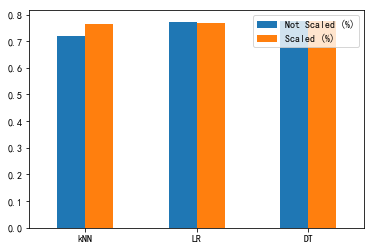

In [36]:
# 为未归一化和归一化的数据绘制分组柱状图，可视化的图和下图相似即可
# 对models_auc_df数据进行可视化，要求设置图例到右下角，标题为未归一化和归一化数据的模型AUC值比较

#解决图例中文显示问题，设置字体样式
plt.rcParams['font.sans-serif']=['SimHei']  
plt.rcParams['axes.unicode_minus']=False 

#创建画布
plt.figure(figsize=(20,12), dpi=120)

models_auc_df.plot(kind='bar')

plt.xticks(rotation=360)

依据对未归一化和归一化后的数据训练模型，通过对模型的AUC值进行比较，可以发现：归一化能有效提高KNN模型的AUC值，但是对逻辑回归和决策树的影响不大。